# CICY Topology ML - Exploratory Data Analysis

This notebook explores the CICY dataset structure, data distributions, and key statistics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.insert(0, os.path.abspath('..'))

sns.set_style('whitegrid')
%matplotlib inline

## 1. Load Raw Data

**What we'll do:** Load the three main data files (X_cicy3, X_enhanced, y_hodge) from disk.

**Why it matters:** Before building or training a model, we need to understand what data we're working with. We'll inspect:
- The shape of each array (how many samples, how many features)
- The data types (float32 for images, int64 for labels)

**What the results tell us:**
- `X_cicy3.npy` contains raw CICY configuration matrices (one per 3-fold geometry)
- `X_enhanced.npy` is the same data but with additional geometric features appended
- `y_hodge.npy` contains pairs of topological invariants we want to predict

In [2]:
# Load processed data
X_cicy3 = np.load('../data/processed/X_cicy3.npy')
X_enhanced = np.load('../data/processed/X_enhanced.npy')
y_hodge = np.load('../data/processed/y_hodge.npy')

print(f"X_cicy3 shape: {X_cicy3.shape}")
print(f"X_enhanced shape: {X_enhanced.shape}")
print(f"y_hodge shape: {y_hodge.shape}")
print(f"\nData types:")
print(f"X_cicy3: {X_cicy3.dtype}")
print(f"X_enhanced: {X_enhanced.dtype}")
print(f"y_hodge: {y_hodge.dtype}")

X_cicy3 shape: (7890, 12, 15)
X_enhanced shape: (7890, 181)
y_hodge shape: (7890, 2)

Data types:
X_cicy3: float32
X_enhanced: float32
y_hodge: int64


## 2. Target Variable Analysis (Hodge Numbers)

**What we'll do:** Analyze the distribution of Hodge numbers (h^{1,1} and h^{2,1}).

**Why it matters:** Understanding the target variable is crucial. We need to know:
- How many unique values exist (is this classification or regression?)
- Are the classes balanced or imbalanced? (affects training strategy)
- What's the range of values we need to predict?

**What the results mean:**
- Each manifold has two Hodge numbers (a pair)
- If there are ~10-50 unique values for each, this is a classification problem
- If the counts are very imbalanced (e.g., one value has 90% of samples), the model may be biased

In [3]:
# Hodge numbers are pairs: [h^{1,1}, h^{2,1}]
print("Hodge numbers statistics:")
print(f"Number of samples: {y_hodge.shape[0]}")
print(f"\nh^(1,1) - min: {y_hodge[:, 0].min()}, max: {y_hodge[:, 0].max()}, mean: {y_hodge[:, 0].mean():.2f}")
print(f"h^(2,1) - min: {y_hodge[:, 1].min()}, max: {y_hodge[:, 1].max()}, mean: {y_hodge[:, 1].mean():.2f}")

print(f"\nUnique h^(1,1) values: {len(np.unique(y_hodge[:, 0]))}")
print(f"Unique h^(2,1) values: {len(np.unique(y_hodge[:, 1]))}")

# Value counts
print(f"\nTop 10 h^(1,1) values:")
unique_h11, counts_h11 = np.unique(y_hodge[:, 0], return_counts=True)
for val, count in sorted(zip(unique_h11, counts_h11), key=lambda x: -x[1])[:10]:
    print(f"  {int(val)}: {int(count)} samples")

Hodge numbers statistics:
Number of samples: 7890

h^(1,1) - min: 0, max: 19, mean: 7.42
h^(2,1) - min: 0, max: 101, mean: 28.74

Unique h^(1,1) values: 18
Unique h^(2,1) values: 65

Top 10 h^(1,1) values:
  7: 1463 samples
  8: 1328 samples
  6: 1257 samples
  9: 1036 samples
  5: 856 samples
  10: 648 samples
  4: 425 samples
  11: 372 samples
  12: 161 samples
  3: 155 samples


## 3. Feature Exploration

**What we'll do:** Separate the enhanced features into image data (the 12×15 matrix) and scalar geometric features.

**Why it matters:** The CNN takes two types of input:
- 2D image data (the CICY configuration matrix)
- 1D scalar features (geometric properties like ambient factor count)

Understanding this separation helps us see how the model combines different types of information.

**What the results tell us:**
- First 180 features are the flattened 12×15 matrix
- Remaining features are scalar geometric descriptors
- The mean values tell us if features are roughly on the same scale (or if normalization is needed)

In [4]:
# X_enhanced contains image data (180 features) and scalar geometric features
n_image_features = 180
n_scalar_features = X_enhanced.shape[1] - n_image_features

X_img = X_enhanced[:, :n_image_features]
X_scalar = X_enhanced[:, n_image_features:]

print(f"Image features: {X_img.shape}")
print(f"Scalar features: {X_scalar.shape}")
print(f"\nScalar feature statistics:")
print(f"  Min: {X_scalar.min(axis=0)[:5]}...")  # First 5
print(f"  Max: {X_scalar.max(axis=0)[:5]}...")
print(f"  Mean: {X_scalar.mean(axis=0)[:5]}...")

Image features: (7890, 180)
Scalar features: (7890, 1)

Scalar feature statistics:
  Min: [1.]...
  Max: [12.]...
  Mean: [6.540684]...


## 4. Data Distribution Plots

**What we'll do:** Visualize the distributions of Hodge numbers and feature values.

**Why it matters:** Visualization helps us spot:
- **Skewed distributions:** If h^{1,1} or h^{2,1} are heavily skewed, the model may struggle with rare classes
- **Outliers:** Extreme values that could affect training
- **Relationships:** Do h^{1,1} and h^{2,1} correlate? (If yes, they share topological constraints)

**What the plots show:**
- Histograms tell us how many 3-folds have each Hodge number value
- The scatter plot shows if larger h^{1,1} tends to go with larger h^{2,1} (or independent)
- The boxplot shows if image features have normal or unusual distributions

C:\Users\HP\AppData\Local\Temp\ipykernel_25416\4177011050.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([X_img.flatten()], labels=['Image Features'])


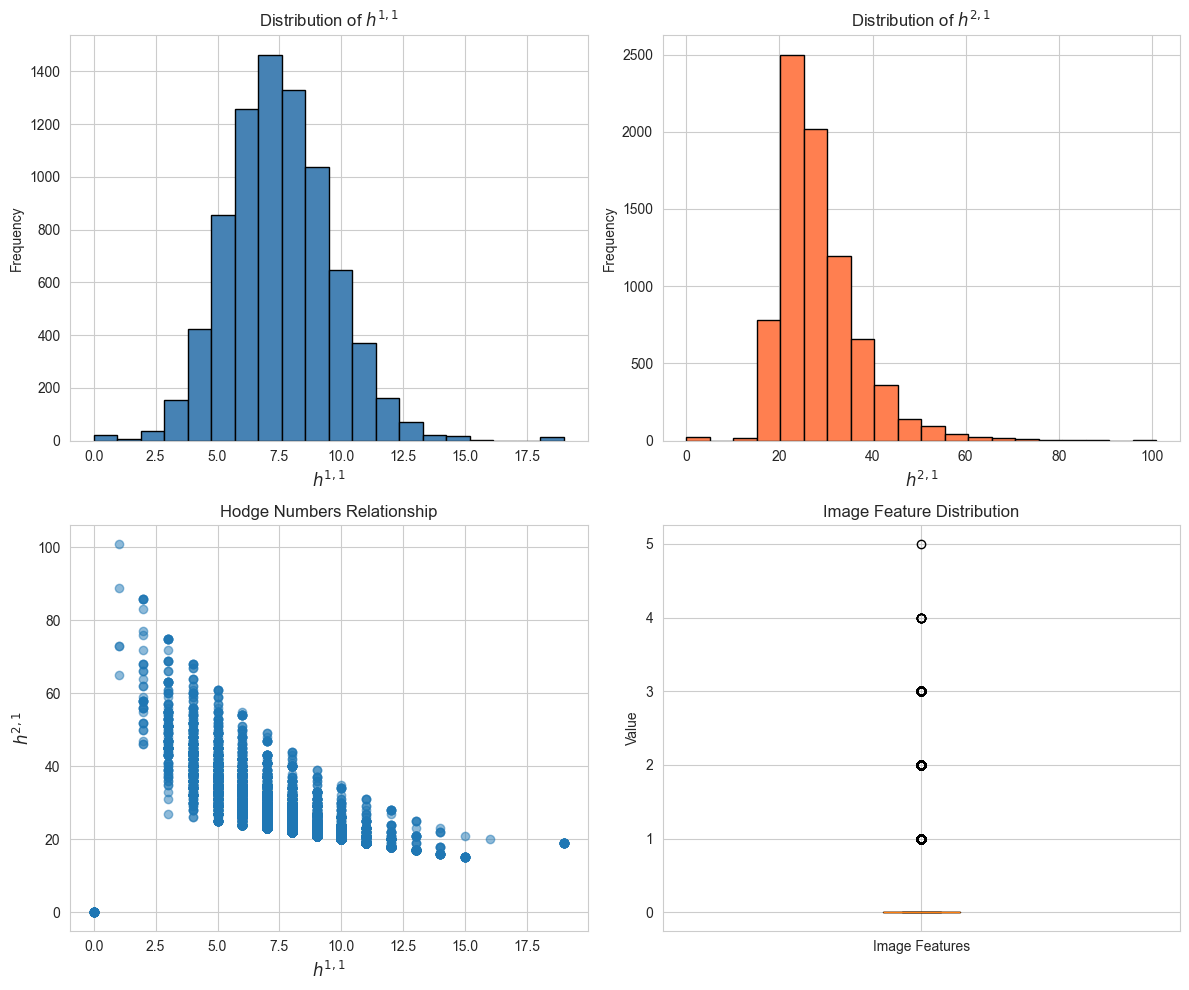

Plot saved to plots/01_eda_distributions.png


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# h^{1,1} distribution
axes[0, 0].hist(y_hodge[:, 0], bins=20, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel(r'$h^{1,1}$', fontsize=12)
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of $h^{1,1}$')

# h^{2,1} distribution
axes[0, 1].hist(y_hodge[:, 1], bins=20, color='coral', edgecolor='black')
axes[0, 1].set_xlabel(r'$h^{2,1}$', fontsize=12)
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of $h^{2,1}$')

# Scatter: h^{1,1} vs h^{2,1}
axes[1, 0].scatter(y_hodge[:, 0], y_hodge[:, 1], alpha=0.5)
axes[1, 0].set_xlabel(r'$h^{1,1}$', fontsize=12)
axes[1, 0].set_ylabel(r'$h^{2,1}$', fontsize=12)
axes[1, 0].set_title('Hodge Numbers Relationship')

# Image feature statistics
axes[1, 1].boxplot([X_img.flatten()], labels=['Image Features'])
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_title('Image Feature Distribution')

plt.tight_layout()
plt.savefig('../plots/01_eda_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to plots/01_eda_distributions.png")

## 5. Sample Visualization

**What we'll do:** Display a few random CICY configuration matrices and their corresponding Hodge numbers.

**Why it matters:** Visual inspection helps us:
- See what the raw data looks like (pattern, sparsity, magnitude)
- Build intuition for why a CNN might work (spatial patterns in the matrix)
- Check for data quality issues (all zeros, NaNs, etc.)

**What we'll observe:**
- Each matrix is 12×15 with numerical values (0-100 typically)
- Some matrices may be sparse (mostly zeros) or dense
- The Hodge numbers are relatively simple integers (this is discrete geometry!)

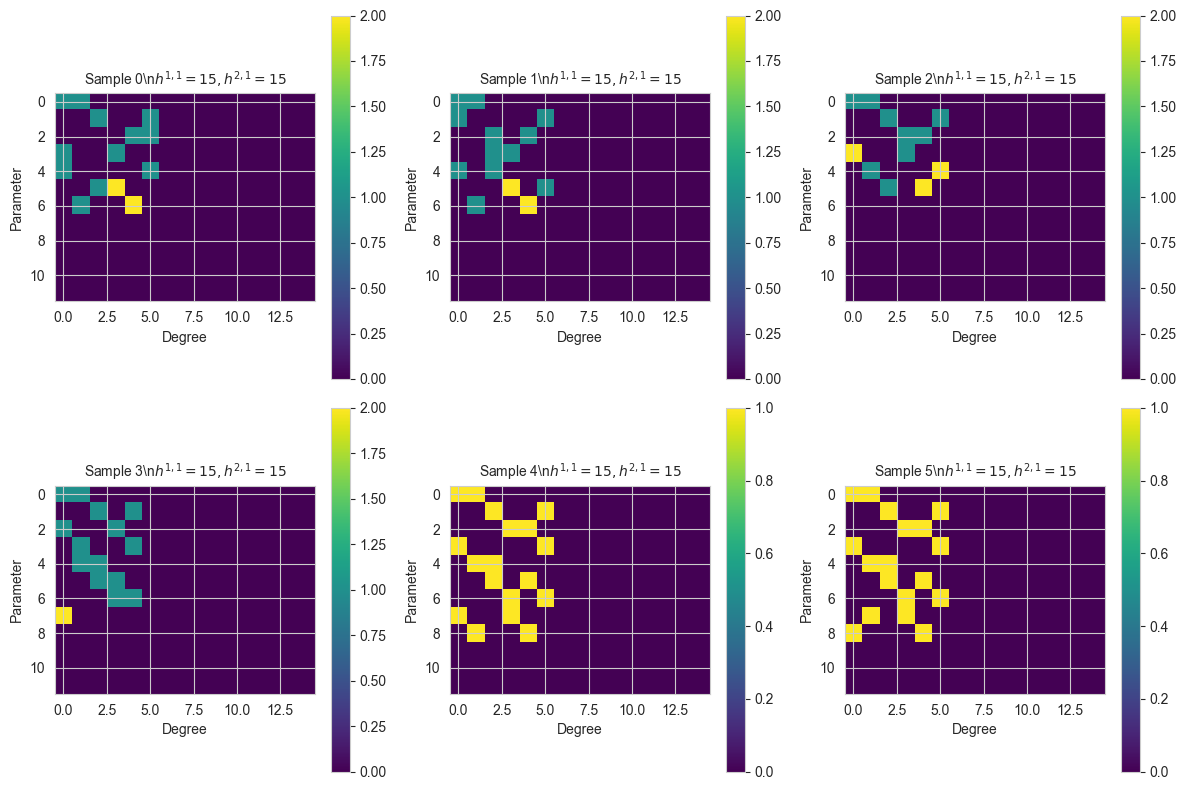

Sample visualization saved to plots/02_sample_matrices.png


In [6]:
# Visualize sample CICY matrices
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for idx in range(6):
    ax = axes[idx // 3, idx % 3]
    sample_img = X_img[idx].reshape(12, 15)
    h11 = y_hodge[idx, 0]
    h21 = y_hodge[idx, 1]
    
    im = ax.imshow(sample_img, cmap='viridis')
    ax.set_title(f'Sample {idx}\\n$h^{{1,1}}={h11}, h^{{2,1}}={h21}$', fontsize=10)
    ax.set_xlabel('Degree') 
    ax.set_ylabel('Parameter')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('../plots/02_sample_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample visualization saved to plots/02_sample_matrices.png")

## 6. Correlation Analysis

**What we'll do:** Calculate how strongly each scalar feature correlates with each Hodge number.

**Why it matters:** 
- **High correlation (close to ±1):** A feature is a strong predictor and may be used directly by the model
- **Low correlation (close to 0):** A feature isn't directly related (but might interact with other features)
- This helps us understand which features are "useful" for the prediction task

**What the results mean:**
- If the ambient factor has correlation 0.8 with h^{1,1}, it's very important
- If a feature has correlation 0.05, it barely helps as a direct predictor
- The model may learn non-linear relationships even between weakly-correlated features

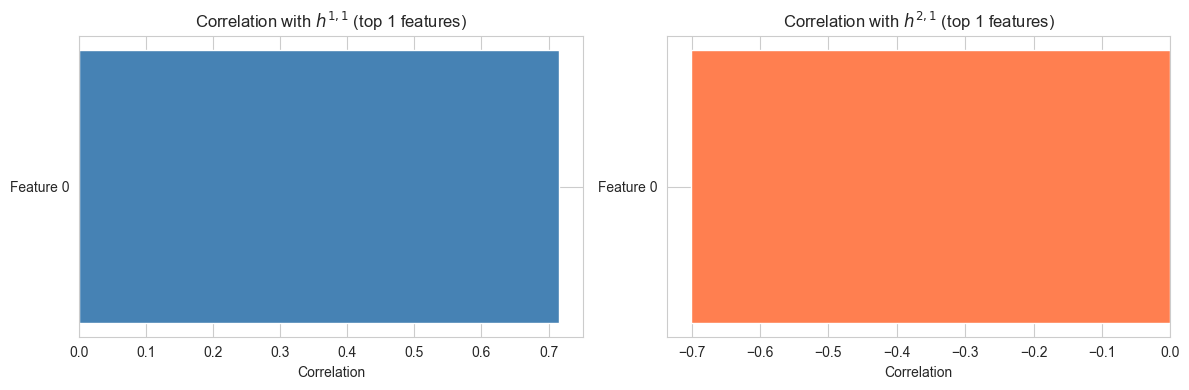

Feature correlation plot saved to plots/03_feature_correlation.png


In [7]:
# Check correlation between scalar features and targets
if X_scalar.shape[1] > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Correlation with h^{1,1}
    corr_h11 = np.array([np.corrcoef(X_scalar[:, i], y_hodge[:, 0])[0, 1] 
                          for i in range(min(5, X_scalar.shape[1]))])
    axes[0].barh(range(len(corr_h11)), corr_h11, color='steelblue')
    axes[0].set_xlabel('Correlation')
    axes[0].set_title(f'Correlation with $h^{{1,1}}$ (top {len(corr_h11)} features)')
    axes[0].set_yticks(range(len(corr_h11)))
    axes[0].set_yticklabels([f'Feature {i}' for i in range(len(corr_h11))])
    
    # Correlation with h^{2,1}
    corr_h21 = np.array([np.corrcoef(X_scalar[:, i], y_hodge[:, 1])[0, 1] 
                          for i in range(min(5, X_scalar.shape[1]))])
    axes[1].barh(range(len(corr_h21)), corr_h21, color='coral')
    axes[1].set_xlabel('Correlation')
    axes[1].set_title(f'Correlation with $h^{{2,1}}$ (top {len(corr_h21)} features)')
    axes[1].set_yticks(range(len(corr_h21)))
    axes[1].set_yticklabels([f'Feature {i}' for i in range(len(corr_h21))])
    
    plt.tight_layout()
    plt.savefig('../plots/03_feature_correlation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Feature correlation plot saved to plots/03_feature_correlation.png")
else:
    print("No scalar features to analyze.")